In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pickle
import random as rnd
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import seaborn as sns
import sklearn
import statsmodels.api as sm
import xgboost as xgb
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
from matplotlib import pyplot
from matplotlib.font_manager import FontProperties
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import (AdaBoostRegressor, BaggingClassifier,
                              BaggingRegressor, ExtraTreesRegressor,
                              GradientBoostingRegressor, RandomForestRegressor,
                              VotingRegressor)
from sklearn.feature_selection import (RFE, SelectFromModel, SelectKBest,
                                       VarianceThreshold, chi2)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import (ElasticNet, HuberRegressor, Lasso,
                                  LinearRegression, RANSACRegressor, Ridge,
                                  SGDRegressor, TheilSenRegressor)
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, log_loss,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (Binarizer, LabelEncoder, MinMaxScaler,
                                   Normalizer, OneHotEncoder,
                                   PolynomialFeatures, StandardScaler,
                                   normalize)
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [3]:
traindf = pd.read_csv('../data/train.csv', index_col="ID")
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34476,Resort Hotel,0,275,2016,April,16,10,2,5,2,0.0,0,HB,GBR,Groups,Direct,0,0,0,D,D,0,No Deposit,273.0,NaN,0,Transient-Party,7.099322,0,0,Check-Out,2016-04-17
87678,Resort Hotel,0,1,2017,March,10,7,0,1,2,0.0,0,BB,FRA,Direct,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Transient,58.270374,0,2,Check-Out,2017-03-08


### Drop columns not in test data and Clean missing data
* Drop columns: `adr`, `reservation_status`, `reservation_status_date`

In [4]:
testCol = set(pd.read_csv('../data/test.csv', index_col="ID").columns)
removeCols = [col for col in traindf.columns if col not in testCol]
removeCols.remove("is_canceled")
print(removeCols)

['adr', 'reservation_status', 'reservation_status_date']


In [5]:
traindf = traindf.drop(['reservation_status', 'reservation_status_date'], axis=1)
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8605,City Hotel,1,200,2015,September,37,12,2,1,2,0.0,0,HB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1.0,NaN,0,Transient-Party,79.388916,0,0
64888,City Hotel,0,22,2016,October,41,5,0,2,3,0.0,0,BB,FRA,Offline TA/TO,TA/TO,0,0,0,A,D,0,No Deposit,28.0,NaN,0,Transient,110.985884,0,0


### Drop outliers

* Drop if booking is canceled
* Drop if adr is lower than 0 and higher than 400

In [6]:
traindf = traindf[traindf["is_canceled"] == 0]
traindf = traindf[(traindf["adr"] > 0) & (traindf["adr"] < 400)]

In [7]:
traindf.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,City Hotel,0,257,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,6.0,NaN,0,Transient,75.052227,0,0
2,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,74.546401,0,0
3,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,76.376288,0,0
4,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,49.411647,0,0
5,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,92.832887,0,0


### EDA

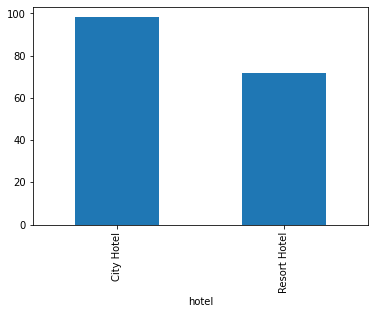

In [8]:
traindf.groupby("hotel")["adr"].agg("mean").plot.bar()

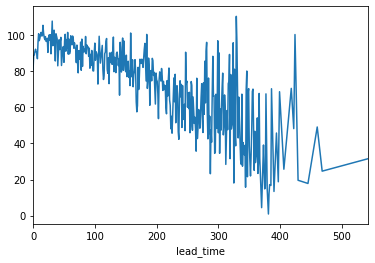

In [9]:
traindf.groupby("lead_time")["adr"].agg("mean").plot()

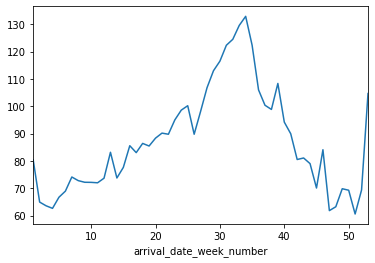

In [10]:
traindf.groupby("arrival_date_week_number")["adr"].agg("mean").plot()

In [59]:
def create_date(year: pd.Series, month: pd.Series, date: pd.Series) -> pd.Series:
    return pd.to_datetime(year.astype(str) + month + date.astype(str), format="%Y%B%d")

tmp = traindf.copy()
tmp.insert(loc=0, column="date", 
          value=create_date(tmp["arrival_date_year"], tmp["arrival_date_month"], tmp["arrival_date_day_of_month"]))
tmp["weekday"] = tmp["date"].dt.weekday
tmp["is_weekend"] = ((tmp["weekday"] == 5) | (tmp["weekday"] == 6)).astype("float")

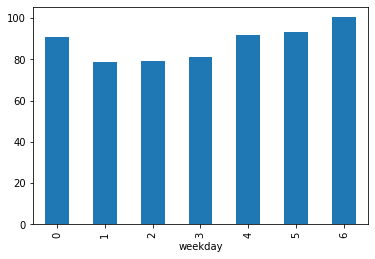

In [12]:
tmp.groupby("weekday")["adr"].agg("mean").plot.bar()

In [13]:
tmp.groupby(["weekday", "arrival_date_month"])["adr"].agg("mean")

weekday  arrival_date_month
0        April                  82.165240
         August                124.928742
         December               74.351943
         February               74.350662
         January                67.184561
         July                  115.327524
         June                  100.094379
         March                  79.008973
         May                    92.062699
         November               73.267339
         October                88.918562
         September             101.597164
1        April                  71.545602
         August                119.397107
         December               63.688944
         February               62.557180
         January                57.593770
         July                  106.219711
         June                   91.029305
         March                  61.779456
         May                    79.433690
         November               57.469516
         October                79.229560
      

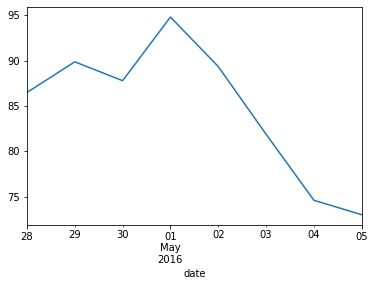

In [14]:
tmp[tmp["date"].between("2016-04-28", "2016-05-05")].groupby("date")["adr"].agg("mean").plot()

In [15]:
tmp.groupby("is_weekend")["adr"].agg("mean")

is_weekend
0.0    84.886603
1.0    96.368711
Name: adr, dtype: float64

In [16]:
tmp["is_same_room"] = (tmp["reserved_room_type"] == tmp["assigned_room_type"]).map({True: 1, False: 0})
tmp.groupby("is_same_room")["adr"].agg("mean")

is_same_room
0    78.149303
1    90.583264
Name: adr, dtype: float64

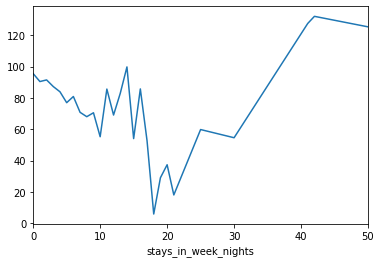

In [17]:
tmp.groupby("stays_in_week_nights")["adr"].agg("mean").plot()

In [18]:
# stays_in_weekend_nights stays_in_week_nights
# tmp.groupby("stays_in_weekend_nights")["adr"].agg("mean").plot()
tmp["total_nights"] = tmp["stays_in_weekend_nights"] + tmp["stays_in_week_nights"]
tmp = tmp[tmp["total_nights"] > 0]
tmp["long_stay"] = (tmp["total_nights"] > 5).astype("float")
tmp.groupby("long_stay")["adr"].agg(["mean", "count"])

,mean,count
long_stay,,
0.0,90.081433,49102
1.0,77.977806,8072


In [62]:
# adults	children	babies
tmp["total_customers"] = tmp["adults"] + tmp["children"] + tmp["babies"]
# tmp = tmp[tmp["total_customers"] <= 5]
tmp.groupby("total_customers")["adr"].agg(["mean", "count"])

,mean,count
total_customers,,
0.0,22.144559,101
1.0,71.868500,12986
2.0,85.512939,37666
3.0,124.036594,5043
4.0,164.749984,1585
5.0,188.682524,63
10.0,114.178012,1
12.0,74.480789,1


In [20]:
tmp.groupby("meal")["adr"].agg(["mean", "count"])

,mean,count
meal,,
BB,86.514200,44794
FB,113.490348,260
HB,97.148227,6973
SC,94.045521,4397
Undefined,75.761264,748


In [32]:
tmp.groupby("country")["adr"].agg(["mean", "count"]).sort_values(by="mean", ascending=False)

,mean,count
country,,
AIA,279.633649,1
AND,232.838445,1
PAK,173.660472,1
ABW,170.863316,1
TMP,166.025944,2
MMR,160.089103,1
GAB,147.951058,2
ARE,147.749176,6
SLV,147.448945,1


In [34]:
tmp["PRT"] = (tmp["country"] == "PRT").astype("float")
tmp.groupby("PRT")["adr"].agg(["mean", "count"]).sort_values(by="mean", ascending=False)

,mean,count
PRT,,
0.0,89.808761,39903
1.0,85.053433,17269


In [40]:
x = tmp[["country", "adr"]].groupby("country").agg({'country': 'count', 'adr': 'mean'})
set(x[x["adr"] < 80]["country"].index)

# 1. low: < 80 2. medium: 80 ~ 90 3. high: >90

{'ALB',
 'ARM',
 'ASM',
 'BDI',
 'BHR',
 'CAF',
 'CIV',
 'COM',
 'CYM',
 'GBR',
 'GHA',
 'GTM',
 'IRL',
 'ISL',
 'JAM',
 'JOR',
 'KEN',
 'KNA',
 'LKA',
 'LTU',
 'LVA',
 'MDG',
 'MKD',
 'MNE',
 'MUS',
 'MYS',
 'OMN',
 'PRI',
 'RWA',
 'SEN',
 'SMR',
 'SRB',
 'SUR',
 'TGO',
 'UZB',
 'ZWE'}

In [44]:
tmp.groupby("is_repeated_guest")["adr"].agg(["mean", "count"])

,mean,count
is_repeated_guest,,
0,89.415826,54903
1,63.124574,2269


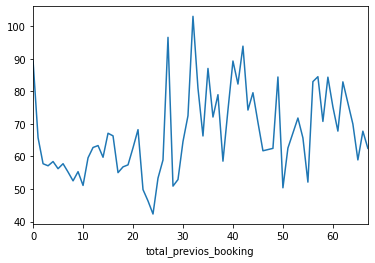

In [64]:
# previous_cancellations	previous_bookings_not_canceled
tmp["total_previos_booking"] = tmp["previous_cancellations"] + tmp["previous_bookings_not_canceled"]
tmp.groupby("total_previos_booking")["adr"].agg(["mean", "count"]).plot()

In [57]:
tmp.groupby("customer_type")["adr"].agg(["mean", "count"])

,mean,count
customer_type,,
Contract,83.597486,2183
Group,74.055764,391
Transient,93.569747,39464
Transient-Party,75.878230,15134


In [66]:
tmp[["agent", "adr"]].groupby("agent").agg({'agent': 'count', 'adr': 'mean'}).sort_values(by="adr", ascending=False)

,agent,adr
agent,,
404.0,2,285.423509
426.0,3,229.103081
70.0,1,221.293503
232.0,2,182.979965
414.0,2,173.241151
254.0,21,170.793790
438.0,2,168.406638
289.0,1,160.871084
285.0,1,152.943129
